In [61]:
%pip install optuna cebra==0.4.0 matplotlib==3.9.2 numpy pandas scipy seaborn umap_learn pyspark python-dotenv tensorboardX umap-learn

Note: you may need to restart the kernel to use updated packages.


In [62]:
import sys
sys.path.append("/main/external/dimensionality-reduction")

In [63]:
from cebra import CEBRA
import torch
import torch.utils
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from utils.utils import spark_rdd_to_tensor
from utils.overrides import transform
from tqdm import tqdm
import dotenv
import os
dotenv.load_dotenv()
dotenv.load_dotenv("/main/external/dimensionality-reduction/.env")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [64]:
embedding = CEBRA.load("/main/external/models/embedding_0.pt")
decoder = torch.load("/main/external/models/decoder_0.pt")

/opt/conda/lib/python3.11/site-packages/cebra/integrations/sklearn/cebra.py:1436: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename, **kwargs)
/

# Data Load

In [65]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

MAX_MEMORY = "120g"

spark = SparkSession \
    .builder \
    .appName("UranusCluster") \
    .appName("Foo") \
    .config("spark.executor.memory", MAX_MEMORY) \
    .config("spark.driver.memory", MAX_MEMORY) \
    .config("spark.memory.offHeap.enabled",True)\
    .config("spark.memory.offHeap.size","16g")   \
    .getOrCreate()

# Verify the SparkContext
print(spark.sparkContext.getConf().getAll())

[('spark.driver.memory', '120g'), ('spark.app.id', 'local-1734605602529'), ('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false'), ('spark.app.name', 'Foo'), ('sp

In [66]:
#Taking just one because this still doesn`t support multi session data
DATA_PATH = "ID18150/Day6/DataFrame_Imaging_spiking_18150_day6"

In [67]:
df = spark.read.format("parquet").load("/main/external/data/transformed")\
    .select(["index","neural_data", "positional_encoding", "file_name"])\
    .where(F.col("file_name") == DATA_PATH)
df.show(5)

+------------+--------------------+--------------------+--------------------+
|       index|         neural_data| positional_encoding|           file_name|
+------------+--------------------+--------------------+--------------------+
|317827579904|[0.00353814595291...|0.014736815295795708|ID18150/Day6/Data...|
|317827707084|[7.32697662897408...|0.002792727523517...|ID18150/Day6/Data...|
|317827579905|[0.00376488942492...|0.014736815295795708|ID18150/Day6/Data...|
|317827707085|[5.27972821146249...|0.002792727523517...|ID18150/Day6/Data...|
|317827579906|[0.00368517413153...| 0.01473313965622418|ID18150/Day6/Data...|
+------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [68]:
sample = df.sample(False, 0.01).collect()
X = spark_rdd_to_tensor(sample, "neural_data")
y = spark_rdd_to_tensor(sample, "positional_encoding")
X_embed = transform(embedding, X)

In [69]:
reducer = umap.UMAP(n_components=3)
U = reducer.fit_transform(X_embed)

/opt/conda/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [70]:
def scatter_3d(data):
    """
    Creates a 3d scatter plot of the input.
    
    Parameters
    ----------
    data : array_like
        Input data of shape (n_samples, 3)
    """
    assert data.shape[1] == 3, "Input data must have 3 features"
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:,0], data[:,1], data[:,2])
    return ax

<Axes3D: >

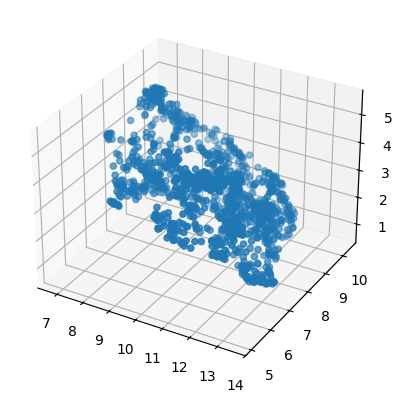

In [71]:
scatter_3d(U)

In [72]:
y_pred = decoder(torch.Tensor(X_embed)).flatten().detach().numpy()
y = y.flatten()

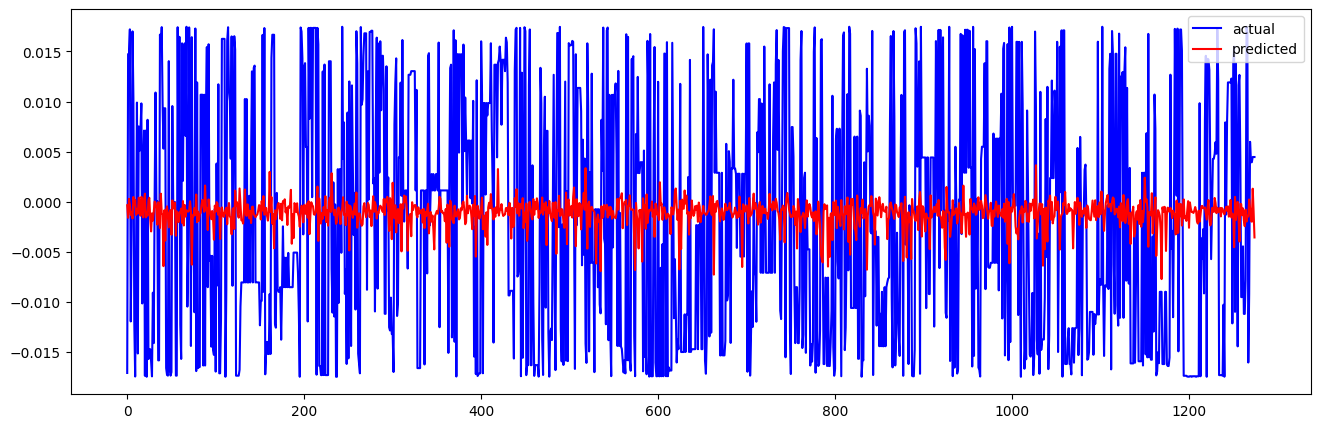

In [73]:
plt.figure(figsize=(16,5))
plt.plot(y, color='blue', label='actual')
plt.plot(y_pred, color='red', label='predicted')
plt.legend()
plt.show()
